In [4]:
import CMZoom_utility as cmz
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from scipy.special import erf
import astrodendro
import os
from astropy import wcs
from astrodendro import Dendrogram, pp_catalog
from astrodendro.analysis import PPStatistic
from astropy.table import Table, hstack, Column
from astropy.utils.console import ProgressBar
import reproject
import pyregion
print(np.__version__)
import aplpy


1.16.5


In [5]:
%matplotlib inline

In [6]:
##################################################################################################
### setup 
##################################################################################################
## picks for the accurate catalog
rms = 3.0e6
dend_min_v = 3
dend_min_d = 1
dend_min_pix = 17
prune_min_peak = 6
prune_min_mean = 2
path = '/Users/hph/cmzoom_catalog/catalog_acc/'
catalog = Table.read(path+'catalog_acc.fits')
#######################################
### picks for the complete catalog
# rms = 3.0e6
# dend_min_v = 3
# dend_min_d = 1
# dend_min_pix = 17
# prune_min_peak = 4
# prune_min_mean = 2
# path = '/Users/hph/cmzoom_catalog/catalog_complete/'
# catalog = Table.read(path+'catalog_complete.fits')
#################################################

### set condition to exclude sgrA*
#ca = (catalog['mask_num']==27)
#catalog.remove_rows(ca)
#######################################

date = '_02-02-20'
targetname = '_rms3e6_k14_dv'+str(dend_min_v)+'_dd'+str(dend_min_d)+'_dp'+str(dend_min_pix)+'_pp'+str(prune_min_peak)+'_pm'+str(prune_min_mean)+'_gal'+date

sma_path = path
herschel_path = path
catalog_path = path
figure_path = path

/Users/hph/anaconda/envs/cmzoom3/lib/python3.6/site-packages/reproject/interpolation/core_celestial.py:26: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(array.dtype, np.float):


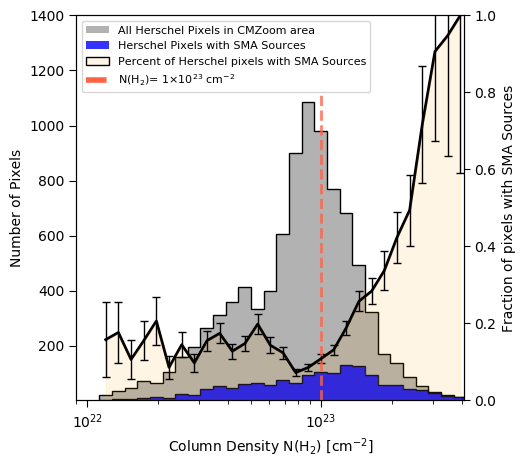

In [7]:
#################################################
### Make figure of Herschel column density
#################################################
#catalog = table_hdu[1].data
column_file = os.path.join(path, 'column_properunits_conv36_source_only.fits')
sma_file = os.path.join(path, 'CMZoom_continuum_pbcor.fits')
sma_mosaic = fits.open(sma_file)
sma_orig = sma_mosaic[0].data
sma_observed = np.isfinite(sma_orig)
column_fh = fits.open(column_file)

smaobserved_projto_herschel,_ = reproject.reproject_interp((sma_observed,
                                                            wcs.WCS(sma_mosaic[0].header).celestial),
                                                           column_fh[0].header)
smaobserved_projto_herschel[np.isnan(smaobserved_projto_herschel)] = 0
smaobserved_projto_herschel = smaobserved_projto_herschel.astype('bool')
colwcs = wcs.WCS(column_fh[0].header)
pix = colwcs.wcs_world2pix(catalog['glon'], catalog['glat'], 0)
column_dens = column_fh[0].data[pix[1].astype('int'), pix[0].astype('int')]

# column density file handle
column_fh = fits.open(column_file)
column_masked = column_fh[0].data
column_masked[~smaobserved_projto_herschel] = np.nan

sb2_mask = pyregion.open(os.path.join('/Users/hph/Dropbox/CMZoom_Data/prototype_catalog/', 
                                      'sgrb2mask.reg')).get_mask(column_fh[0])

colmin = np.nanmin(column_masked[~sb2_mask])
colmax = np.nanmax(column_masked[~sb2_mask])


smasourcemask = np.zeros_like(smaobserved_projto_herschel, dtype='bool')

# for each source, "mask" a region that is within a herschel beam as "this region contains a source"
herschel_beamsize_pixels = (25*u.arcsec / np.mean(wcs.utils.proj_plane_pixel_scales(colwcs)*u.deg)).decompose()

# make a small radial mask
npix = int(np.ceil(herschel_beamsize_pixels))
yy,xx = np.indices([npix*2]*2, dtype='float')
rad = ((yy-npix+0.5)**2 + (xx-npix+0.5)**2)**0.5
radmask = rad < herschel_beamsize_pixels

pb = ProgressBar(len(catalog))
for row,(cx,cy) in zip(catalog, zip(*pix)):
    cy = int(np.round(cy))
    cx = int(np.round(cx))
    smasourcemask[cy-npix:cy+npix,cx-npix:cx+npix][radmask] = True
    pb.update()

plt.close()
plt.rcParams.update(plt.rcParamsDefault)
#plt.style.use('seaborn-colorblind')
#sns.set_style("whitegrid", {'axes.grid' : False})

# Plot Histogram
plt.rcParams.update({'font.size': 10}) #set fontsize
histfig = plt.figure(3,figsize=(5,5))
histfig.clf()
ax = histfig.gca()
plt.ylabel('Number of Pixels')
plt.xlabel('Column Density N(H$_2$) [cm$^{-2}$]')
#plt.legend(loc='upper left', shadow=False, fontsize=18)

#bins = np.logspace(22.9,23.9,100)
binnum = 30

linbins = np.linspace(colmin, colmax,binnum)
logbins = np.logspace(np.log10(colmin), np.log10(colmax),binnum)
h1,l1,p1 = ax.hist(column_masked[np.isfinite(column_masked) & ~sb2_mask],
                   logbins, color='black',alpha=0.3, log=False,
                   label='Full cloud')
h1,l1,p1 = ax.hist(column_masked[np.isfinite(column_masked) & ~sb2_mask],
                   logbins, color='black',alpha=1.0, log=False,histtype='step')
h2,l2,p2 = ax.hist(column_masked[smasourcemask & np.isfinite(column_masked) &
                                 ~sb2_mask], logbins, alpha=.85, log=False, color='blue',
                   label='SMA Sources')
h2,l2,p2 = ax.hist(column_masked[smasourcemask & np.isfinite(column_masked) &
                                 ~sb2_mask], logbins, alpha=.85, log=False, color='k', histtype='step')

ax3 = ax.twinx()
midpts = (l1[:-1] + l1[1:])/2.
p3 = line_frac = ax3.plot(midpts, h2/h1, linestyle='-', color='k', 
                     linewidth=2.0, zorder=-21,label='Fraction of pixels with SMA Sources')
perr = np.sqrt((h2/(h1**2))+((h2**2)/(h1**3)))
ax3.errorbar(midpts,h2/h1,yerr=perr,color='k',capsize=3.0,linewidth=1)
ax3.set_ylabel("Fraction of pixels with SMA Sources")
ax3.set_ylim(0,1)
fill = ax3.fill_between(midpts,h2/h1, color='orange',alpha=0.1)
ax3.set_label('Fraction of pixels with SMA Sources')
#ax.legend(line_frac,'Fraction of pixels with SMA Sources')
#ax3.legend(loc='upper right', shadow=False, fontsize=18)

vx, vy = [1e23,1e23],[0,0.8]

p4 = ax3.plot(vx,vy,linestyle='--',linewidth=2.0,alpha=0.8,
              color='tomato', label='N(H$_2$)= 2$\times$10$^{23}$ cm$^{-2}$')
ax.set_xscale("log")


ax.set_xlim(9.0e21, colmax-1e22)

ax.set_ylim(1,1400)
#plt.gcf().subplots_adjust(bottom=0.2) #make room for x-axis
ax.tick_params(axis='both',which='major',direction='out',length=5)
ax.tick_params(axis='both',which='major',direction='out',length=5)
ax.tick_params(axis='both',which='minor',direction='out',length=3)
ax.tick_params(axis='both',which='minor',direction='out',length=3)
ax3.tick_params(axis='both',which='major',direction='out',length=4)

#labs = [h1.get_label(),h2.get_label(),p3.get_label(),p4.get_label()]
plt.rcParams.update({'font.size': 8})
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='k',alpha=0.3, edgecolor='None',
                         label='All Herschel Pixels in CMZoom area'),
                   Patch(facecolor='b',alpha=0.8, edgecolor='None',
                         label='Herschel Pixels with SMA Sources'),
                   Patch(facecolor='#FEF5E7',alpha=0.99, edgecolor='k',
                         label='Percent of Herschel pixels with SMA Sources'),
                   Line2D([0], [0], color='tomato', lw=4, ls='--', label='N(H$_2$)= 1$\\times$10$^{23}$ cm$^{-2}$')]

ax.legend(handles=legend_elements, loc='upper left')

# Save figure
# Need to save it as a PDF, otherewise, lose transparency
plt.savefig(figure_path + 'column_histograms_log'+targetname+'.pdf',format='pdf', dpi=100, bbox_inches='tight')

plt.show()

print(perr)

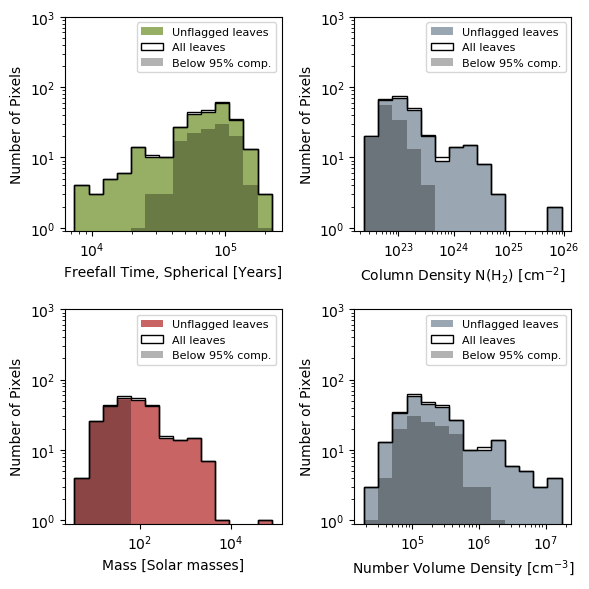

In [8]:
#########################################################
### Histograms but with suspicion separation
#########################################################
#rlim = 0.12
incomp = (catalog['mass']<60)
scond= (catalog['suspicious']==1)
nscond= (catalog['suspicious']==0)
tff_arr = catalog['tff']
Column_N = catalog['sma_column']
mass_arr = catalog['mass']
Vol_n = catalog['n']

plt.close()
plt.rcParams.update(plt.rcParamsDefault)
#plt.rcParams.update({'font.size': 16}) #set fontsize
fig, axarr = plt.subplots(ncols=2,nrows=2,figsize=(6,6))
###
axarr[0,0].set_ylabel('Number of Pixels')
axarr[0,0].set_xlabel('Freefall Time, Spherical [Years]')

tffmin, tffmax = min(tff_arr), max(tff_arr)
tff_logbins = np.logspace(np.log10(tffmin), np.log10(tffmax),15)
h1,l1,p1 = axarr[0,0].hist(tff_arr[nscond],
                   tff_logbins, color='olivedrab',alpha=0.7, log=True,
                   label='Unflagged leaves')
h1,l1,p1 = axarr[0,0].hist(tff_arr[nscond],
                   tff_logbins, color='k',alpha=1.0,histtype='step', log=True)
# h1,l1,p1 = axarr[0,0].hist(tff,
#                    tff_logbins, color='k',alpha=0.5, log=True,
#                    label='r > '+str(rlim))
h1,l1,p1 = axarr[0,0].hist(tff_arr,
                   tff_logbins, color='k',alpha=1.0,histtype='step', log=True, label='All leaves')
h1,l1,p1 = axarr[0,0].hist(tff_arr[incomp],
                   tff_logbins, color='k',alpha=0.3,log=True, label='Below 95% comp.')

axarr[0,0].set_xscale("log")
axarr[0,0].legend(loc='best', shadow=False, fontsize=8)
axarr[0,0].set_ylim(0.9,1000)
####
axarr[0,1].set_ylabel('Number of Pixels')
axarr[0,1].set_xlabel('Column Density N(H$_2$) [cm$^{-2}$]')

Nmin, Nmax = min(Column_N[scond]), max(Column_N[nscond])
Nmin, Nmax = min(Column_N), max(Column_N)
N_logbins = np.logspace(np.log10(Nmin), np.log10(Nmax),15)

h1,l1,p1 = axarr[0,1].hist(Column_N[nscond],
                   N_logbins, color='slategrey',alpha=0.7, log=True,
                   label='Unflagged leaves')
h1,l1,p1 = axarr[0,1].hist(Column_N[nscond],
                   N_logbins, color='k',alpha=1.0,histtype='step', log=True)
# h1,l1,p1 = axarr[0,1].hist(Column_N,
#                    N_logbins, color='k',alpha=0.2, log=True,
#                    label='r > '+str(rlim))
h1,l1,p1 = axarr[0,1].hist(Column_N,
                   N_logbins, color='k',alpha=1.0,histtype='step', log=True, label='All leaves')
h1,l1,p1 = axarr[0,1].hist(Column_N[incomp],
                   N_logbins, color='k',alpha=0.3, log=True, label='Below 95% comp.')

axarr[0,1].set_xscale("log")
axarr[0,1].legend(loc='best', shadow=False, fontsize=8)
axarr[0,1].set_ylim(0.9,1000)

####
axarr[1,0].set_ylabel('Number of Pixels')
axarr[1,0].set_xlabel('Mass [Solar masses]')


#massmin, massmax = min(mass_arr[nscond]), max(mass_arr[nscond])
massmin, massmax = min(mass_arr), max(mass_arr)
logbins = np.logspace(np.log10(massmin), np.log10(massmax),15)
h12,l1,p1 = axarr[1,0].hist(mass_arr[nscond],
                   logbins, color='firebrick',alpha=0.7, log=True,
                   label='Unflagged leaves')
h12,l1,p1 = axarr[1,0].hist(mass_arr[nscond],
                   logbins, color='k',alpha=1.0,histtype='step', log=True)
# h12,l1,p1 = axarr[1,0].hist(mass,
#                    logbins, color='k',alpha=0.2, log=True,
#                    label='r > '+str(rlim))
h12,l1,p1 = axarr[1,0].hist(mass_arr,
                   logbins, color='k',alpha=1.0,histtype='step', log=True, label='All leaves')
h12,l1,p1 = axarr[1,0].hist(mass_arr[incomp],
                   logbins, color='k',alpha=0.3, log=True, label='Below 95% comp.')

axarr[1,0].set_xscale("log")
axarr[1,0].legend(loc='best', shadow=False, fontsize=8)
axarr[1,0].set_ylim(0.9,1000)


axarr[1,1].set_ylabel('Number of Pixels')
axarr[1,1].set_xlabel('Number Volume Density [cm$^{-3}$]')
nmin, nmax = min(Vol_n[nscond]), max(Vol_n[nscond])
n_logbins = np.logspace(np.log10(nmin), np.log10(nmax),15)
h1,l1,p1 = axarr[1,1].hist(Vol_n[nscond],
                   n_logbins, color='slategrey',alpha=0.7, log=True,
                   label='Unflagged leaves')
h1,l1,p1 = axarr[1,1].hist(Vol_n[nscond],
                   n_logbins, color='k',alpha=1.0,histtype='step', log=True)
# h1,l1,p1 = axarr[1,1].hist(Vol_n,
#                    n_logbins, color='k',alpha=0.2, log=True,
#                    label='r > '+str(rlim))
h1,l1,p1 = axarr[1,1].hist(Vol_n,
                   n_logbins, color='k',alpha=1.0,histtype='step', log=True, label='All leaves')
h1,l1,p1 = axarr[1,1].hist(Vol_n[incomp],
                   n_logbins, color='k',alpha=0.3, log=True, label='Below 95% comp.')

axarr[1,1].set_xscale("log")
axarr[1,1].legend(loc='best', shadow=False, fontsize=8)
axarr[1,1].set_ylim(0.9,1000)

####

plt.tight_layout()

# Save figure
# Need to save it as a PDF, otherewise, lose transparency
plt.savefig(figure_path + 'histogram_4panel'+targetname+'.pdf',format='pdf', dpi=100, bbox_inches='tight')
plt.show()


In [9]:
###############################
### find lower cutoff for MR
###############################
r_arr = np.linspace(0.001,50,10)
r_arr_pc = (r_arr/206265)*cmz.distance
lowrms=3e6 #jy/sr
lowcut=3*lowrms #3 sigma limit on leaf edge pixel flux
lowcut_bgsub = 1*lowrms
intflux = lowcut*np.pi*(r_arr/206265)**2
intflux_bgsub = lowcut_bgsub*((r_arr*1)/206265)**2#(1.-(1./np.exp(1)))*(r_arr/206265)**2
#lowcut_bgsub*(1.-(1./np.exp(1)))*(r_arr/206265)**2 #lowcut_bgsub*np.pi*(r_arr/206265)**2
### find mass from integrated flux
masscut = cmz.mass_calc_submm(cmz.Wave, 20.0, 
                              cmz.Kappa, intflux, cmz.distance)
masscut_bgsub = cmz.mass_calc_submm(cmz.Wave, 20.0, 
                              cmz.Kappa, intflux_bgsub, cmz.distance)
print(np.log10(masscut_bgsub))
print(np.log10(masscut))
print(np.log10(r_arr))


[-6.9604389   0.52915506  1.13113688  1.48329334  1.73315779  1.92697
  2.08532728  2.21921714  2.33519824  2.43750111]
[-5.98616777  1.50342618  2.10540801  2.45756447  2.70742892  2.90124113
  3.05959841  3.19348826  3.30946937  3.41177224]
[-3.          0.74479698  1.04578789  1.22186612  1.34679834  1.44370445
  1.52288309  1.58982802  1.64781857  1.69897   ]


In [12]:
    print(catalog['mass'][i]/catalog['mass_unc'][i])

       mass       
        Jy        
------------------
 3.264640001196442
 6.407782934007451
 4.883256949631342
 3.465765509649891
 4.072287373119636
 4.620665744574482
 6.593584337668476
 4.190097443892363
 5.919095987340547
  4.62229957329265
               ...
 5.266920123187113
5.8993343644048055
 6.262707934630718
 4.955907429974485
 5.493604983237854
  5.03466399992061
  4.71122357443759
 4.425681532666293
 4.618967257582016
3.9040993961140185
Length = 285 rows


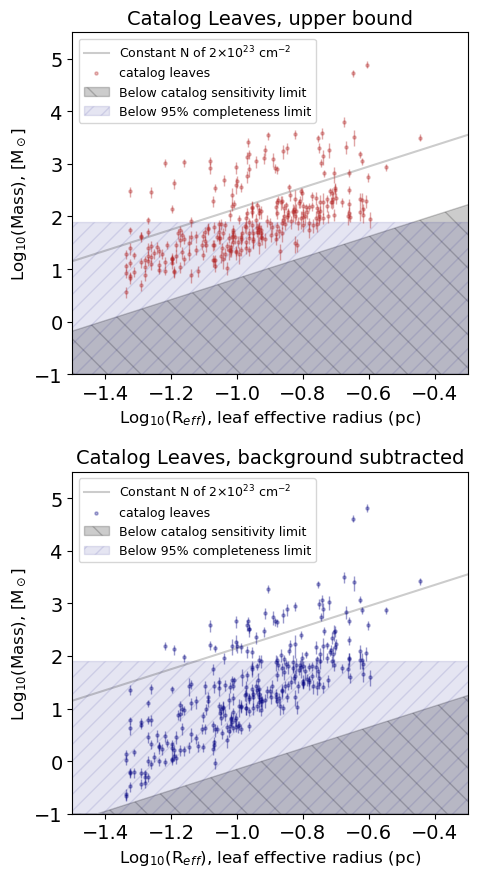

In [10]:
mass = catalog['mass']
r_eff_pc = catalog['r_eff_pc']
noise_mass = catalog['mass_unc']
incomp = (catalog['mass']<80)
logyerr=(np.log10(mass)-np.log10(mass-noise_mass),
            np.log10(mass+noise_mass)-np.log10(mass))
mass_bin = np.array([min(mass),max(mass)])
radius_vals = cmz.radius_from_mass_const_col_density(mass_bin,2.0*10**23)
mass_bgsub = catalog['mass_bgsub']

plt.close()
plt.rcParams.update({'font.size': 14}) #set fontsize

f = plt.figure(figsize=(5,9))

ax1 = f.add_subplot(211)
ax1.set_title('Catalog Leaves, upper bound',fontsize=14)
ax1.scatter( np.log10(r_eff_pc),np.log10(mass),s=20, color='firebrick',
             alpha=.3,marker='.',zorder=2000,label='catalog leaves')
ax1.errorbar(x=np.log10(r_eff_pc),y=np.log10(mass),
             yerr=logyerr,
             ls='none',color='firebrick',alpha=.4,marker='', linewidth=1.0,zorder=2000)
ax1.plot(np.log10(radius_vals),np.log10(mass_bin),color='k',
         label='Constant N of 2$\\times$10$^{23}$ cm$^{-2}$',alpha=0.2)
ax1.fill_between(np.log10(r_arr_pc),np.zeros_like(masscut)-1.,np.log10(masscut),color='k',
                 label='Below catalog sensitivity limit',alpha=0.2,hatch='\\')
ax1.fill_between(np.log10(r_arr_pc),np.zeros_like(masscut)-1.,np.repeat(np.log10(80),len(r_arr_pc)),color='navy',
                 label='Below 95% completeness limit',alpha=0.1,hatch='//')
ax1.set_xlabel('Log$_{10}$(R$_e$$_f$$_f$), leaf effective radius (pc)',fontsize=12)
ax1.set_ylabel('Log$_{10}$(Mass), [M$_\odot$]',fontsize=12)
ax1.set_ylim(-1,5.5)
ax1.set_xlim(-1.5,-0.3)
ax1.legend(loc='upper left', shadow=False, fontsize=9)

ax2 = f.add_subplot(212)
ax2.set_title('Catalog Leaves, background subtracted',fontsize=14)
ax2.scatter( np.log10(r_eff_pc),np.log10(mass_bgsub),s=20, color='navy',
             alpha=.3,marker='.',zorder=2000,label='catalog leaves')
ax2.errorbar(x=np.log10(r_eff_pc),y=np.log10(mass_bgsub),
             yerr=logyerr,
             ls='none',color='navy',alpha=.4,marker='', linewidth=1.0,zorder=2000)
ax2.plot(np.log10(radius_vals),np.log10(mass_bin),color='k',
         label='Constant N of 2$\\times$10$^{23}$ cm$^{-2}$',alpha=0.2)
ax2.fill_between(np.log10(r_arr_pc),np.zeros_like(masscut_bgsub)-1.,np.log10(masscut_bgsub),color='k',
                 label='Below catalog sensitivity limit',alpha=0.2,hatch='\\')
ax2.fill_between(np.log10(r_arr_pc),np.zeros_like(masscut_bgsub)-1.,
                 np.repeat(np.log10(80),len(r_arr_pc)),color='navy',
                 label='Below 95% completeness limit',alpha=0.1,hatch='//')
ax2.set_xlabel('Log$_{10}$(R$_e$$_f$$_f$), leaf effective radius (pc)',fontsize=12)
ax2.set_ylabel('Log$_{10}$(Mass), [M$_\odot$]',fontsize=12)
ax2.set_ylim(-1,5.5)
ax2.set_xlim(-1.5,-0.3)
ax2.legend(loc='upper left', shadow=False, fontsize=9)

plt.tight_layout()

# Save figure
# Need to save it as a PDF, otherewise, lose transparency
plt.savefig(figure_path + 'twofig_subtracted_mass_radius'+targetname+'.pdf',
            format='pdf', dpi=100, bbox_inches='tight')
plt.show()

In [21]:
mass = catalog['mass']
r_eff_pc = catalog['r_eff_pc']
noise_mass = np.sqrt(4*catalog['mass']+catalog['mass_unc']**2)
incomp = (catalog['mass']<80)
logyerr=(np.log10(mass)-np.log10(mass-noise_mass),
            np.log10(mass+noise_mass)-np.log10(mass))
mass_bin = np.array([min(mass),max(mass)])
radius_vals = cmz.radius_from_mass_const_col_density(mass_bin,2.0*10**23)
mass_bgsub = catalog['mass_bgsub']

plt.close()
plt.rcParams.update({'font.size': 14}) #set fontsize

f = plt.figure(figsize=(5,9))

ax1 = f.add_subplot(211)
ax1.set_title('Catalog Leaves, upper bound',fontsize=14)
ax1.scatter( r_eff_pc,mass,s=20, color='firebrick',
             alpha=.3,marker='.',zorder=2000,label='catalog leaves')
ax1.errorbar(x=r_eff_pc,y=mass,
             yerr=noise_mass,
             ls='none',color='firebrick',alpha=.4,marker='', linewidth=1.0,zorder=2000)
ax1.plot(radius_vals,mass_bin,color='k',
         label='Constant N of 2$\\times$10$^{23}$ cm$^{-2}$',alpha=0.2)
ax1.fill_between(r_arr_pc,np.zeros_like(masscut)-10.,masscut,color='k',
                 label='Below catalog sensitivity limit',alpha=0.2,hatch='\\')
ax1.fill_between(r_arr_pc,np.zeros_like(masscut)-1.,np.repeat(80,len(r_arr_pc)),color='navy',
                 label='Below 95% completeness limit',alpha=0.1,hatch='//')
ax1.set_xlabel('R, leaf effective radius (pc)',fontsize=12)
ax1.set_ylabel('Mass, [M$_\odot$]',fontsize=12)
ax1.set_ylim(10**(-1),10**5.5)
ax1.set_xlim(10**-1.5,10**(-0.3))
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.legend(loc='upper left', shadow=False, fontsize=9)

ax2 = f.add_subplot(212)
ax2.set_title('Catalog Leaves, background subtracted',fontsize=14)
ax2.scatter( r_eff_pc,mass_bgsub,s=20, color='navy',
             alpha=.3,marker='.',zorder=2000,label='catalog leaves')
ax2.errorbar(x=r_eff_pc,y=mass_bgsub,
             yerr=noise_mass,
             ls='none',color='navy',alpha=.4,marker='', linewidth=1.0,zorder=2000)
ax2.plot(radius_vals,mass_bin,color='k',
         label='Constant N of 2$\\times$10$^{23}$ cm$^{-2}$',alpha=0.2)
#ax2.fill_between(r_arr_pc,np.zeros_like(masscut_bgsub)-1.,masscut_bgsub,color='k',
#                 label='Below catalog sensitivity limit',alpha=0.2,hatch='\\')
ax2.fill(x=np.concatenate(r_arr_pc,r_arr_pc), y=np.concatenate(np.zeros_like(masscut_bgsub)-1.,masscut_bgsub),
         fc='none', alpha=0.3, ec='black', zorder=30)
ax2.fill(x=np.concatenate(r_arr_pc,r_arr_pc), y=np.concatenate(np.zeros_like(masscut_bgsub)-1.,masscut_bgsub),
         color='grey', alpha=0.1, ec='none', zorder=30)
ax2.fill(x=np.concatenate(r_arr_pc,r_arr_pc), y=np.concatenate(np.zeros_like(masscut_bgsub)-1.,masscut_bgsub),
         color='none', alpha=0.3, edgecolor='grey', hatch='///', zorder=30) 

ax2.fill_between(r_arr_pc,np.zeros_like(masscut_bgsub)-1.,
                 np.repeat(80,len(r_arr_pc)),color='navy',
                 label='Below 95% completeness limit',alpha=0.1,hatch='//')
ax2.set_xlabel('R$, leaf effective radius (pc)',fontsize=12)
ax2.set_ylabel('Mass, [M$_\odot$]',fontsize=12)
ax2.set_ylim(10**(-1),10**5.5)
ax2.set_xlim(10**-1.5,10**(-0.3))
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.legend(loc='upper left', shadow=False, fontsize=9)

plt.tight_layout()

# Save figure
# Need to save it as a PDF, otherewise, lose transparency
#plt.savefig(figure_path + 'twofig_subtracted_mass_radius'+targetname+'.pdf',
#            format='pdf', dpi=100, bbox_inches='tight')
plt.show()

/Users/hph/anaconda/envs/cmzoom3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log10
  """


TypeError: only integer scalar arrays can be converted to a scalar index

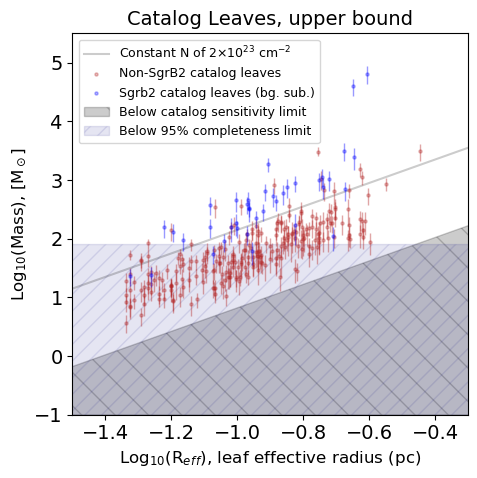

In [94]:
### same but plotting bg sub masses for sgrb2

sgrb2cond = (catalog['mask_num']==9)
nsgrb2cond = (catalog['mask_num']!=9)

mass = catalog['mass']
r_eff_pc = catalog['r_eff_pc']
noise_mass = catalog['mass_unc']
incomp = (catalog['mass']<80)
logyerr_sgrb2=(np.log10(mass[sgrb2cond])-np.log10(mass[sgrb2cond]-noise_mass[sgrb2cond]),
            np.log10(mass[sgrb2cond]+noise_mass[sgrb2cond])-np.log10(mass[sgrb2cond]))
logyerr_nsgrb2=(np.log10(mass[nsgrb2cond])-np.log10(mass[nsgrb2cond]-noise_mass[nsgrb2cond]),
            np.log10(mass[nsgrb2cond]+noise_mass[nsgrb2cond])-np.log10(mass[nsgrb2cond]))
mass_bin = np.array([min(mass),max(mass)])
radius_vals = cmz.radius_from_mass_const_col_density(mass_bin,2.0*10**23)
mass_bgsub = catalog['mass_bgsub']

plt.close()
plt.rcParams.update({'font.size': 14}) #set fontsize

f = plt.figure(figsize=(5,5))

ax1 = f.add_subplot(111)
ax1.set_title('Catalog Leaves, upper bound',fontsize=14)
ax1.scatter( np.log10(r_eff_pc[nsgrb2cond]),np.log10(mass[nsgrb2cond]),s=20, color='firebrick',
             alpha=.3,marker='.',zorder=2000,label='Non-SgrB2 catalog leaves')
ax1.errorbar(x=np.log10(r_eff_pc[nsgrb2cond]),y=np.log10(mass[nsgrb2cond]),
             yerr=logyerr_nsgrb2,
             ls='none',color='firebrick',alpha=.4,marker='', linewidth=1.0,zorder=2000)
ax1.scatter( np.log10(r_eff_pc[sgrb2cond]),np.log10(mass_bgsub[sgrb2cond]),s=20, color='blue',
             alpha=.3,marker='.',zorder=2000,label='Sgrb2 catalog leaves (bg. sub.)')
ax1.errorbar(x=np.log10(r_eff_pc[sgrb2cond]),y=np.log10(mass_bgsub[sgrb2cond]),
             yerr=logyerr_sgrb2,
             ls='none',color='blue',alpha=.4,marker='', linewidth=1.0,zorder=2000)
ax1.plot(np.log10(radius_vals),np.log10(mass_bin),color='k',
         label='Constant N of 2$\\times$10$^{23}$ cm$^{-2}$',alpha=0.2)
ax1.fill_between(np.log10(r_arr_pc),np.zeros_like(masscut)-1.,np.log10(masscut),color='k',
                 label='Below catalog sensitivity limit',alpha=0.2,hatch='\\')
ax1.fill_between(np.log10(r_arr_pc),np.zeros_like(masscut)-1.,np.repeat(np.log10(80),len(r_arr_pc)),color='navy',
                 label='Below 95% completeness limit',alpha=0.1,hatch='//')
ax1.set_xlabel('Log$_{10}$(R$_e$$_f$$_f$), leaf effective radius (pc)',fontsize=12)
ax1.set_ylabel('Log$_{10}$(Mass), [M$_\odot$]',fontsize=12)
ax1.set_ylim(-1,5.5)
ax1.set_xlim(-1.5,-0.3)
ax1.legend(loc='upper left', shadow=False, fontsize=9)

plt.tight_layout()

# Save figure
# Need to save it as a PDF, otherewise, lose transparency
plt.savefig(figure_path + 'sgrb2_mr'+targetname+'.pdf',
            format='pdf', dpi=100, bbox_inches='tight')
plt.show()

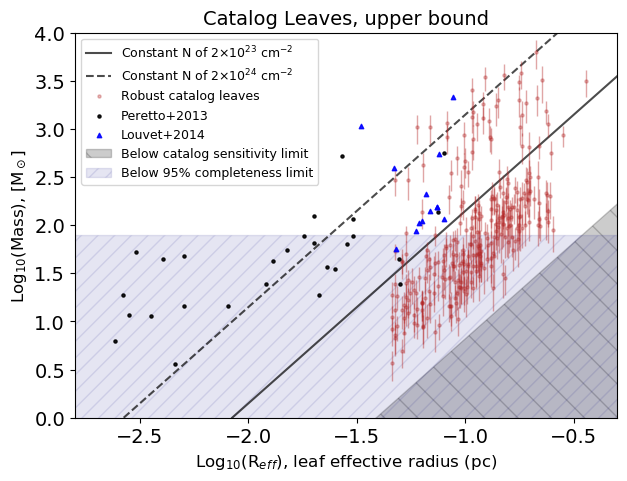

In [114]:
r_peretto =np.array([0.002432,0.002636,0.002829,0.003037,0.003551,0.004029,0.004571,0.005032,0.005032,0.008048,0.01211,
            0.01300,0.01505,0.01805,0.02007,0.02007,0.02111,0.02312,0.02519,0.02704,0.02844,0.03021,0.03037,
            0.04956,0.04981,0.07461,0.07967])
r_louvet = np.array([0.088,0.076,0.066,0.074,0.074,0.069,0.063,0.061,0.048,0.059,0.080,0.033,0.047])
m_peretto =np.array([6.340,19.02,11.73,52.91,11.28,44.56,3.581,14.55,47.57,14.52,24.65,42.69,55.64,76.73,124.3,64.67,
            18.68,36.60,34.89,519.4,63.36,78.03,115.0,44.52,24.27,135.9,563.1])
m_louvet =np.array([2128,545,211,153,153,141,111,105,56,88,115,1080,395])

mass = catalog['mass']
r_eff_pc = catalog['r_eff_pc']
noise_mass = catalog['mass_unc']
incomp = (catalog['mass']<80)
logyerr=(np.log10(mass)-np.log10(mass-noise_mass),
            np.log10(mass+noise_mass)-np.log10(mass))
mass_bin = np.array([1,max(mass)])
radius_vals1 = cmz.radius_from_mass_const_col_density(mass_bin,2.0*10**23)
radius_vals2 = cmz.radius_from_mass_const_col_density(mass_bin,2.0*10**24)

mass_bgsub = catalog['mass_bgsub']

plt.close()
plt.rcParams.update({'font.size': 14}) #set fontsize

f = plt.figure(figsize=(7,5))

ax1 = f.add_subplot(111)
ax1.set_title('Catalog Leaves, upper bound',fontsize=14)
ax1.scatter( np.log10(r_eff_pc),np.log10(mass),s=20, color='firebrick',
             alpha=.3,marker='.',zorder=2000,label='Robust catalog leaves')
ax1.errorbar(x=np.log10(r_eff_pc),y=np.log10(mass),
             yerr=logyerr,
             ls='none',color='firebrick',alpha=.4,marker='', linewidth=1.0,zorder=2000)

ax1.scatter( np.log10(r_peretto),np.log10(m_peretto),s=20, color='k',
             alpha=.9,marker='.',zorder=2000,label='Peretto+2013')
ax1.scatter( np.log10(r_louvet),np.log10(m_louvet),s=10, color='blue',
             alpha=.9,marker='^',zorder=2000,label='Louvet+2014')

ax1.plot(np.log10(radius_vals1),np.log10(mass_bin),color='k',
         label='Constant N of 2$\\times$10$^{23}$ cm$^{-2}$',alpha=0.7)
ax1.plot(np.log10(radius_vals2),np.log10(mass_bin),color='k',ls='--',
         label='Constant N of 2$\\times$10$^{24}$ cm$^{-2}$',alpha=0.7)

ax1.fill_between(np.log10(r_arr_pc),np.zeros_like(masscut)-1.,np.log10(masscut),color='k',
                 label='Below catalog sensitivity limit',alpha=0.2,hatch='\\')
ax1.fill_between(np.log10(r_arr_pc),np.zeros_like(masscut)-1.,np.repeat(np.log10(80),len(r_arr_pc)),color='navy',
                 label='Below 95% completeness limit',alpha=0.1,hatch='//')
ax1.set_xlabel('Log$_{10}$(R$_e$$_f$$_f$), leaf effective radius (pc)',fontsize=12)
ax1.set_ylabel('Log$_{10}$(Mass), [M$_\odot$]',fontsize=12)
ax1.set_ylim(0,4.)
ax1.set_xlim(-2.8,-0.3)
ax1.legend(loc='upper left', shadow=False, fontsize=9)
plt.savefig(path+'core_comparison'+targetname+'.pdf')
plt.show()

In [96]:
# # new "shower" figure based on adam's suggestion
# plt.rcParams.update({'font.size': 12}) #set fontsize
# mrfig = plt.figure(3,figsize=(6,6))
# mrfig.clf()
# ax = mrfig.gca()
# ax.set_xlabel('Log$_{10}$(R$_e$$_f$$_f$), leaf effective radius (pc)',fontsize=12)
# ax.set_ylabel('Log$_{10}$(Mass), [M$_\odot$]',fontsize=12)
# flux_integrated=catalog['flux_integrated']

# ### plot temp bar
# low_dustTemp = 20
# mid_dustTemp = 50
# high_dustTemp = 150

# mass_vals_mid = cmz.mass_calc_submm(cmz.Wave, mid_dustTemp, cmz.Kappa, flux_integrated, cmz.distance)
# mass_vals_high = cmz.mass_calc_submm(cmz.Wave,high_dustTemp, cmz.Kappa, flux_integrated, cmz.distance)
# mass_diff_mid = np.log10(mass_vals_mid) - np.log10(mass)
# mass_diff_high = np.log10(mass_vals_high) - np.log10(mass_vals_mid)

# ax.set_title('Effect of Dust Temperature on Leaf Mass')
# ax.scatter(np.log10(r_eff_pc), np.log10(mass), color='black',alpha=.7, 
#            label='Dust temperature T=20 K',marker='_',s=30.,zorder =22)
# zeros = np.zeros(shape = mass.shape)
# ax.errorbar(x=np.log10(r_eff_pc), y=np.log10(mass_vals_mid),
#             yerr=[mass_diff_mid,zeros], ls='none',color='cornflowerblue',alpha = 0.4,
#             label='Dust temperature ranging from 20K to 50K',capsize=2,linewidth=1.0)

# ax.errorbar(x=np.log10(r_eff_pc), y=np.log10(mass_vals_mid), 
#             yerr=[zeros,mass_diff_high], ls='none',color='tomato',alpha = 0.4,uplims=False,
#             label='Dust temperature ranging from 50K to 150K',capsize=2, zorder=1,linewidth=1.0)

# ax.set_xlim(-1.4,-0.4)
# ax.set_ylim(0,5.0)

# plt.gcf().subplots_adjust(bottom=0.2) #make room for x-axis

# legend = plt.legend(loc='upper left', shadow=False, fontsize=9)#'x-large')


# # Save figure
# # Need to save it as a PDF, otherewise, lose transparency
# plt.savefig(figure_path + 'MR_temp_bar'+targetname+'.pdf',format='pdf', dpi=100, bbox_inches='tight')
# plt.show()

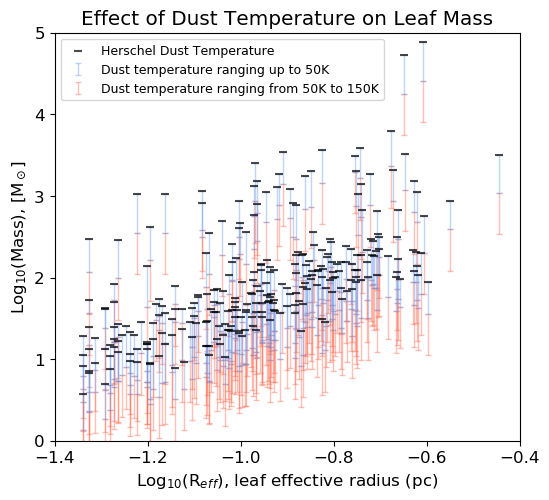

In [97]:
# new "shower" figure based on adam's suggestion
plt.rcParams.update({'font.size': 12}) #set fontsize
mrfig = plt.figure(3,figsize=(6,6))
mrfig.clf()
ax = mrfig.gca()
ax.set_xlabel('Log$_{10}$(R$_e$$_f$$_f$), leaf effective radius (pc)',fontsize=12)
ax.set_ylabel('Log$_{10}$(Mass), [M$_\odot$]',fontsize=12)
flux_integrated=catalog['flux_integrated']

### plot temp bar
low_dustTemp = catalog['DustTemperature']
mid_dustTemp = 50
high_dustTemp = 150

mass_vals_mid = cmz.mass_calc_submm(cmz.Wave, mid_dustTemp, cmz.Kappa, flux_integrated, cmz.distance)
mass_vals_high = cmz.mass_calc_submm(cmz.Wave,high_dustTemp, cmz.Kappa, flux_integrated, cmz.distance)
mass_diff_mid = np.log10(mass_vals_mid) - np.log10(mass)
mass_diff_high = np.log10(mass_vals_high) - np.log10(mass_vals_mid)

ax.set_title('Effect of Dust Temperature on Leaf Mass')
ax.scatter(np.log10(r_eff_pc), np.log10(mass), color='black',alpha=.7, 
           label='Herschel Dust Temperature',marker='_',s=30.,zorder =22)
zeros = np.zeros(shape = mass.shape)
ax.errorbar(x=np.log10(r_eff_pc), y=np.log10(mass_vals_mid),
            yerr=[mass_diff_mid,zeros], ls='none',color='cornflowerblue',alpha = 0.4,
            label='Dust temperature ranging up to 50K',capsize=2,linewidth=1.0)

ax.errorbar(x=np.log10(r_eff_pc), y=np.log10(mass_vals_mid), 
            yerr=[zeros,mass_diff_high], ls='none',color='tomato',alpha = 0.4,uplims=False,
            label='Dust temperature ranging from 50K to 150K',capsize=2, zorder=1,linewidth=1.0)

ax.set_xlim(-1.4,-0.4)
ax.set_ylim(0,5.0)

plt.gcf().subplots_adjust(bottom=0.2) #make room for x-axis

legend = plt.legend(loc='upper left', shadow=False, fontsize=9)#'x-large')


# Save figure
# Need to save it as a PDF, otherewise, lose transparency
plt.savefig(figure_path + 'MR_temp_bar'+targetname+'.pdf',format='pdf', dpi=100, bbox_inches='tight')
plt.show()

In [75]:
plt.close()
vmin=-1.14125e08
vmax =1.07402e+08
gamma=1.8
#fig = plt.figure(figsize=(13, 2))#,facecolor=bg_color, edgecolor=fg_color)
### make lb plot with 
plt.close()
#sns.set_style('white')
glon = catalog['glon']
glat = catalog['glat']
map_l_max = 1.733
map_l_min = 359.1-360
map_b_min = -0.273
map_b_max = 0.111
glon_bins = np.linspace(map_l_min,map_l_max,15)
glat_bins = np.linspace(map_b_min,map_b_max,10)
hdu=fits.open(path+'CMZoom_continuum_pbcor.fits')
data = hdu[0].data
header = hdu[0].header
w = wcs.WCS(path+'CMZoom_continuum_pbcor.fits').celestial
print(data.shape)
glon_pix = np.rint(w.wcs_world2pix(np.flip(glon_bins),0,0)[0])
glon_pix = glon_pix.astype(int)
glat_pix = np.rint(w.wcs_world2pix(0,glat_bins,0)[1])
glat_pix = glat_pix.astype(int)
print("glon weights: ", glon_pix)
#print(glat_pix)

glon_weights = np.zeros_like(glon_pix)
glat_weights = np.zeros_like(glat_pix)

for i in range(len(glon_pix)):
    if i==0:
        glon_weights[i]=np.sum(np.isfinite(data[:,0:glon_pix[i]]))
    else:
        glon_weights[i]=np.sum(np.isfinite(data[:,glon_pix[i-1]:glon_pix[i]]))
        
for i in range(len(glat_pix)):
    if i==0:
        glat_weights[i]=np.sum(np.isfinite(data[0:glat_pix[i],:]))
    else:
        glat_weights[i]=np.sum(np.isfinite(data[glat_pix[i-1]:glat_pix[i],:]))

        

print(glon_weights)
print(glat_weights)


(2800, 19000)
glon weights:  [   31  1385  2739  4093  5447  6802  8156  9510 10864 12218 13572 14926
 16280 17634 18989]
[      0  382737       0       0  421640  440828 1046220  576065  466696
  412700  693715  167345  314859   60932   43785]
[      0   41318   44776   82660  463617 1307566 1351105 1093974  619693
   22813]


/Users/hph/anaconda/envs/cmzoom3/lib/python3.6/site-packages/astropy/visualization/stretch.py:165: RuntimeWarning: invalid value encountered in power
  np.power(values, self.power, out=values)
/Users/hph/anaconda/envs/cmzoom3/lib/python3.6/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/Users/hph/anaconda/envs/cmzoom3/lib/python3.6/site-packages/astropy/visualization/wcsaxes/core.py:225: UserWarning: The following kwargs were not used by contour: 'linestyle'
  cset = super().contour(*args, **kwargs)
/Users/hph/anaconda/envs/cmzoom3/lib/python3.6/site-packages/astropy/visualization/stretch.py:165: RuntimeWarning: invalid value encountered in power
  np.power(values, self.power, out=values)
/Users/hph/anaconda/envs/cmzoom3/lib/python3.6/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/Users/hph/anaconda/envs/cmzoom3/lib/python3.6/site-packages/astropy/visualization/str

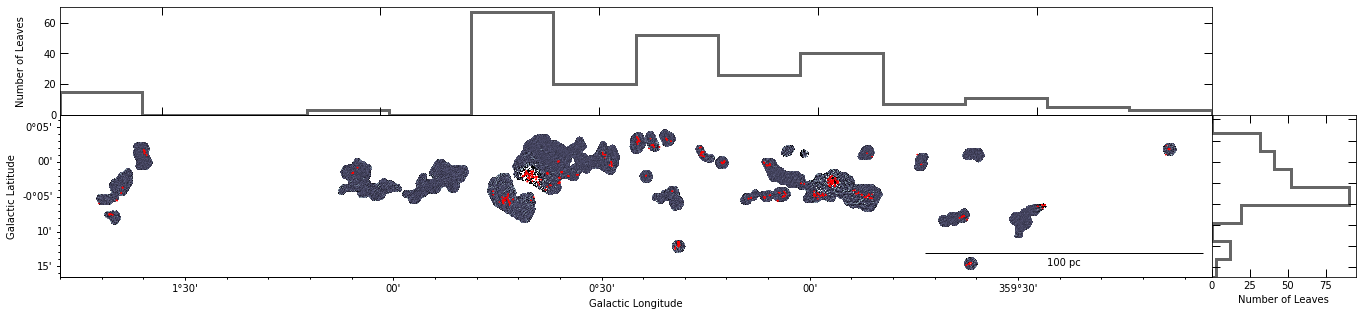

In [76]:
plt.close()
vmin=-1.14125e08
vmax =1.07402e+08
gamma=1.8
#fig = plt.figure(figsize=(13, 2))#,facecolor=bg_color, edgecolor=fg_color)
### make lb plot with 
plt.close()
%matplotlib inline
#sns.set_style('white')
glon = catalog['glon']
glat = catalog['glat']
map_l_max = 1.733
map_l_min = 359.1-360
map_b_min = -0.273
map_b_max = 0.111
glon_bins = np.linspace(map_l_min,map_l_max,15)
glat_bins = np.linspace(map_b_min,map_b_max,10)

xcolor = '#28999b'
ycolor = '#880f8e'#'#d18f02'
xcolor = 'k'
ycolor = 'k'

#mosaic_image = fits.getdata(path+'Continuum_mosaic_current_no_sgra_no_IHMSFR.fits')
left = 0.1
width = 0.8
fig = plt.figure(3,figsize=(20,3))
fig.clf()
plt.rcParams.update({'font.size': 10}) #set fontsize
#ax2 = fig.add_axes([0.1, 0.01, 0.8, 0.75])
subplot = aplpy.FITSFigure(path+'CMZoom_continuum_pbcor.fits', 
                           figure = fig, subplot=[0.1, 0.01, 0.8, 0.75], convention='calabretta')
subplot.show_colorscale(vmin=vmin, vmax=vmax, stretch='power',exponent=gamma,cmap='bone')
subplot.show_contour(path+'dendrogram_mask_pruned'+targetname+'.fits',
                     colors = 'red', levels = [0.0,1.0], linewidths = 0.7,
                     convention = 'calabretta', zorder = 10, linestyle = 'solid')
subplot.set_nan_color('white')
subplot.add_scalebar(length=2400./3600.)
subplot.scalebar.set_label('100 pc')
subplot.scalebar.set_color('k')
ax2=plt.gca()

ax3 = fig.add_axes([.9, 0.01, 0.1, 0.75])#, sharey=ax2)
ax1 = fig.add_axes([0.1, 0.76, 0.8, 0.5])#,sharex=ax1)
ax1.set_ylabel('Number of Leaves', labelpad=18)
h1,l1,m1 = ax1.hist(glon,glon_bins,color=xcolor,orientation='vertical', histtype='step', linewidth=3,
                    alpha=.6,label='Galactic Longitude histogram of leaves')
# h1,l1,m1 = ax1.hist(col_weights,glon_bins,color=xcolor,orientation='vertical',
#                      alpha=.6,label='Galactic Longitude histogram of leaves')
ax1.set_xlim(map_l_min,map_l_max)
ax1.tick_params(width=1, length=8,direction='in',top=True,right=True,bottom=True)
ax1.axes.xaxis.set_ticklabels([])
#ax1.set_yscale('log')
ax1.invert_xaxis()

ax3.set_xlabel('Number of Leaves')
#ax3.tick_params(width=2, length=10, color = ycolor,labelcolor=ycolor,direction='in')
h3, l3, m3 = ax3.hist(glat,glat_bins,orientation='horizontal',color=ycolor, histtype='step', linewidth=3,
         alpha=0.6,label='Galactic Latitude distribution of leaves')
ax3.tick_params(width=1, length=8,direction='in',top=True,right=True,left=True,labelleft=False)
ax3.set_ylim(map_b_min,map_b_max)
#ax3.set_xscale('log')
plt.savefig(path + 'lb_hist'+targetname+'.pdf',format='pdf', dpi=100, bbox_inches='tight')
plt.show()

In [77]:
catalog.keys()

['index',
 'area_ellipse',
 'area_exact',
 'flux_integrated',
 'major_sigma',
 'minor_sigma',
 'position_angle',
 'radius',
 'glon',
 'glat',
 'r_eff',
 'flux_integrated_bgsub',
 'min_flux_integrated',
 'noise',
 'peak_cont_flux',
 'min_cont_flux',
 'mean_cont_flux',
 'npix',
 'DustTemperature',
 'herschel_column',
 'mass',
 'sma_column',
 'r_eff_pc',
 'Sigma',
 'n',
 'rho',
 'tff',
 'glon_0',
 'mass_bgsub',
 'suspicious',
 'leaf_ID',
 'mask_num',
 'mass_unc',
 'N_unc',
 'n_unc',
 'rho_unc',
 'tff_unc']

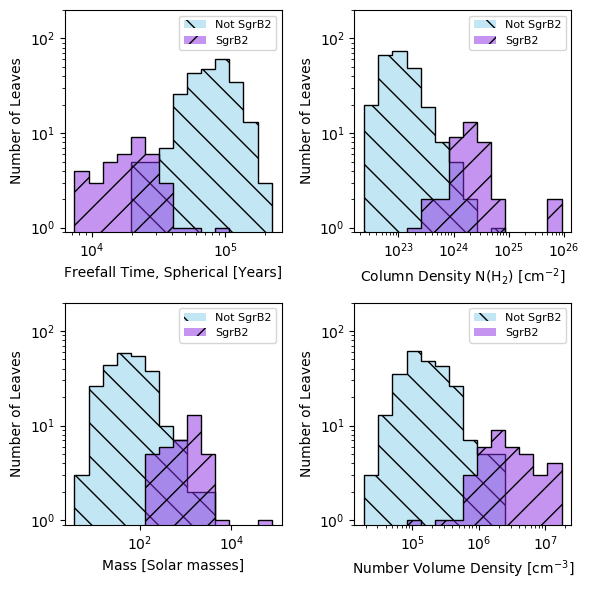

In [98]:
#########################################################
### Histograms but with SgrB2 separation
#########################################################
rlim = 0.12
sgrb2cond = (catalog['mask_num']==9)
nsgrb2cond = (catalog['mask_num']!=9)
tff=catalog['tff']
Column_N=catalog['sma_column']
Vol_n=catalog['n']

plt.close()
plt.rcParams.update(plt.rcParamsDefault)
#plt.rcParams.update({'font.size': 16}) #set fontsize
fig, axarr = plt.subplots(ncols=2,nrows=2,figsize=(6,6))
###
axarr[0,0].set_ylabel('Number of Leaves')
axarr[0,0].set_xlabel('Freefall Time, Spherical [Years]')

tffmin, tffmax = min(tff), max(tff)
tff_logbins = np.logspace(np.log10(tffmin), np.log10(tffmax),15)
h1,l1,p1 = axarr[0,0].hist(tff[nsgrb2cond],
                   tff_logbins, color='skyblue',alpha=0.5,hatch='\\', log=True,
                   label='Not SgrB2')
h1,l1,p1 = axarr[0,0].hist(tff[nsgrb2cond],
                   tff_logbins, color='k',alpha=1.0,histtype='step', log=True)
h1,l1,p1 = axarr[0,0].hist(tff[sgrb2cond],
                   tff_logbins, color='blueviolet',alpha=0.5,hatch='/', log=True,
                   label='SgrB2')
h1,l1,p1 = axarr[0,0].hist(tff[sgrb2cond],
                   tff_logbins, color='k',alpha=1.0,histtype='step', log=True)
axarr[0,0].set_xscale("log")
axarr[0,0].legend(loc='best', shadow=False, fontsize=8)
axarr[0,0].set_ylim(0.9,200)

####
axarr[0,1].set_ylabel('Number of Leaves')
axarr[0,1].set_xlabel('Column Density N(H$_2$) [cm$^{-2}$]')

Nmin, Nmax = min(Column_N), max(Column_N)
N_logbins = np.logspace(np.log10(Nmin), np.log10(Nmax),15)
h1,l1,p1 = axarr[0,1].hist(Column_N[nsgrb2cond],
                   N_logbins, color='skyblue',alpha=0.5, hatch='\\', log=True,
                   label='Not SgrB2')
h1,l1,p1 = axarr[0,1].hist(Column_N[nsgrb2cond],
                   N_logbins, color='k',alpha=1.0,histtype='step', log=True)
h1,l1,p1 = axarr[0,1].hist(Column_N[sgrb2cond],
                   N_logbins, color='blueviolet',alpha=0.5, hatch='/', log=True,
                   label='SgrB2')
h1,l1,p1 = axarr[0,1].hist(Column_N[sgrb2cond],
                   N_logbins, color='k',alpha=1.0,histtype='step', log=True)

axarr[0,1].set_xscale("log")
axarr[0,1].legend(loc='best', shadow=False, fontsize=8)
axarr[0,1].set_ylim(0.9,200)

####
axarr[1,0].set_ylabel('Number of Leaves')
axarr[1,0].set_xlabel('Mass [Solar masses]')


massmin, massmax = min(mass), max(mass)
logbins = np.logspace(np.log10(massmin), np.log10(massmax),15)
h12,l1,p1 = axarr[1,0].hist(mass[nsgrb2cond],
                   logbins, color='skyblue',alpha=0.5,hatch='\\', log=True,
                   label='Not SgrB2')
h12,l1,p1 = axarr[1,0].hist(mass[nsgrb2cond],
                   logbins, color='k',alpha=1.0,histtype='step', log=True)
h12,l1,p1 = axarr[1,0].hist(mass[sgrb2cond],
                   logbins, color='blueviolet',alpha=0.5,hatch='/', log=True,
                   label='SgrB2')
h12,l1,p1 = axarr[1,0].hist(mass[sgrb2cond],
                   logbins, color='k',alpha=1.0,histtype='step', log=True)

axarr[1,0].set_xscale("log")
axarr[1,0].legend(loc='best', shadow=False, fontsize=8)
axarr[1,0].set_ylim(0.9,200)

####

axarr[1,1].set_ylabel('Number of Leaves')
axarr[1,1].set_xlabel('Number Volume Density [cm$^{-3}$]')
nmin, nmax = min(Vol_n), max(Vol_n)
n_logbins = np.logspace(np.log10(nmin), np.log10(nmax),15)
h1,l1,p1 = axarr[1,1].hist(Vol_n[nsgrb2cond],
                   n_logbins, color='skyblue',alpha=0.5, hatch='\\', log=True,
                   label='Not SgrB2')
h1,l1,p1 = axarr[1,1].hist(Vol_n[nsgrb2cond],
                   n_logbins, color='k',alpha=1.0,histtype='step', log=True)
n_logbins = np.logspace(np.log10(nmin), np.log10(nmax),15)
h1,l1,p1 = axarr[1,1].hist(Vol_n[sgrb2cond],
                   n_logbins, color='blueviolet',alpha=0.5, hatch='/',log=True,
                   label='SgrB2')
h1,l1,p1 = axarr[1,1].hist(Vol_n[sgrb2cond],
                   n_logbins, color='k',alpha=1.0,histtype='step',log=True)

axarr[1,1].set_xscale("log")
axarr[1,1].legend(loc='best', shadow=False, fontsize=8)
axarr[1,1].set_ylim(0.9,200)

####

plt.tight_layout()

# Save figure
# Need to save it as a PDF, otherewise, lose transparency
plt.savefig(figure_path + 'sgrb2_4panel'+targetname+'.pdf',format='pdf', dpi=100, bbox_inches='tight')
plt.show()




In [ ]:
#########################################################
### COMPLETE CATALOG FIGS
#########################################################
### load complete catalog:


<IPython.core.display.Javascript object>


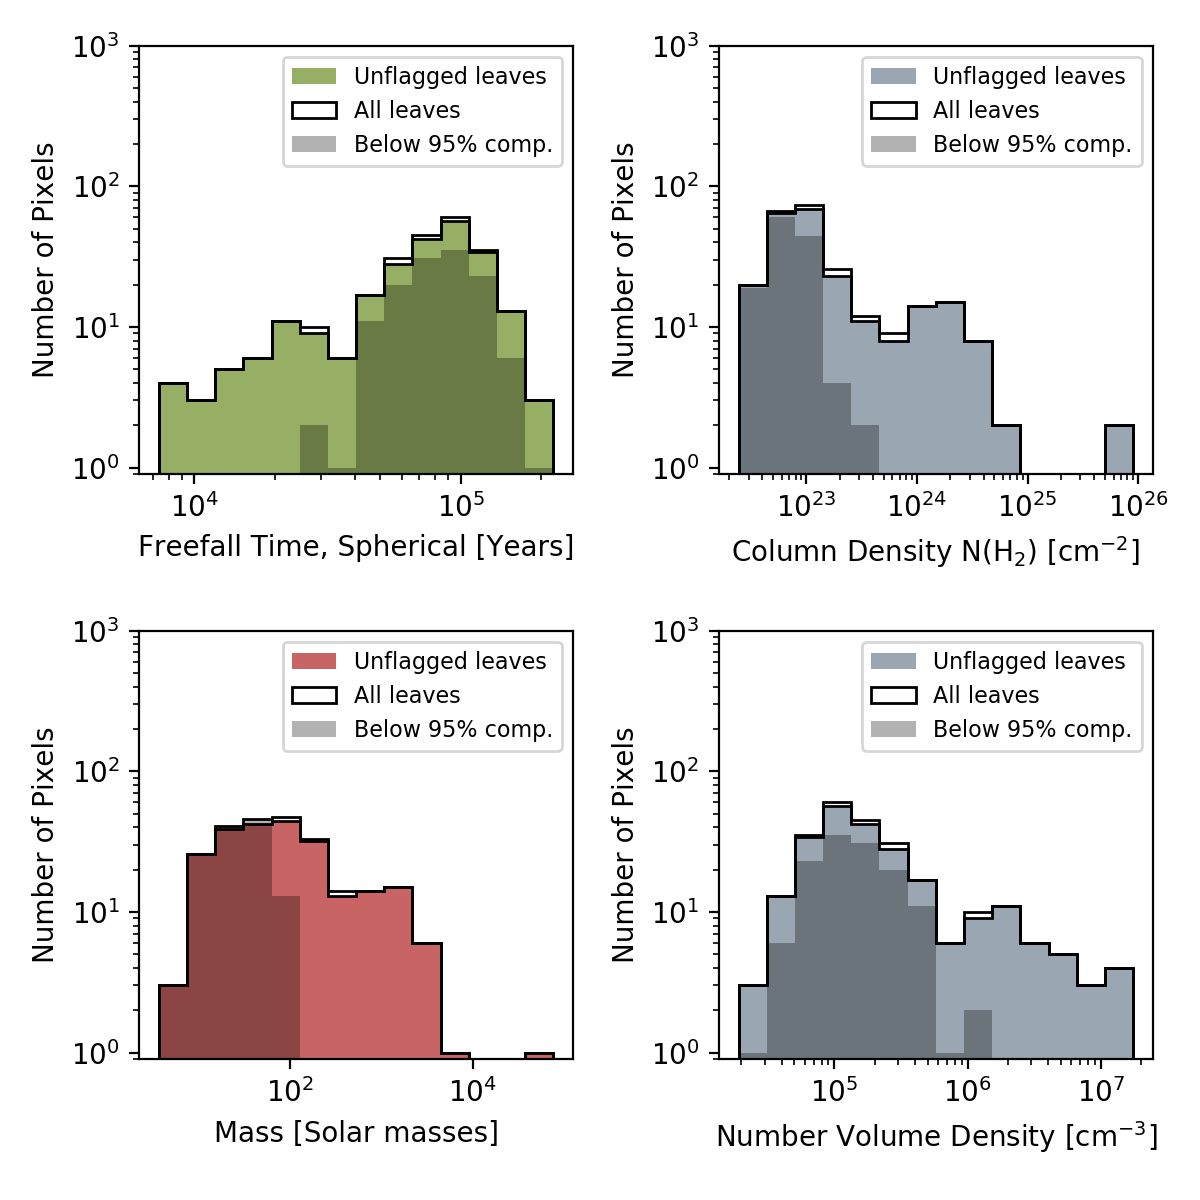

In [13]:
#########################################################
### Histograms but with suspicion separation
#########################################################
#rlim = 0.12
incomp = (catalog['mass']<80)
scond= (catalog['suspicious']==1)
nscond= (catalog['suspicious']==0)
tff_arr = catalog['tff']
Column_N = catalog['sma_column']
mass_arr = catalog['mass']
Vol_n = catalog['n']

plt.close()
plt.rcParams.update(plt.rcParamsDefault)
#plt.rcParams.update({'font.size': 16}) #set fontsize
fig, axarr = plt.subplots(ncols=2,nrows=2,figsize=(6,6))
###
axarr[0,0].set_ylabel('Number of Pixels')
axarr[0,0].set_xlabel('Freefall Time, Spherical [Years]')

tffmin, tffmax = min(tff_arr), max(tff_arr)
tff_logbins = np.logspace(np.log10(tffmin), np.log10(tffmax),15)
h1,l1,p1 = axarr[0,0].hist(tff_arr[nscond],
                   tff_logbins, color='olivedrab',alpha=0.7, log=True,
                   label='Unflagged leaves')
h1,l1,p1 = axarr[0,0].hist(tff_arr[nscond],
                   tff_logbins, color='k',alpha=1.0,histtype='step', log=True)
# h1,l1,p1 = axarr[0,0].hist(tff,
#                    tff_logbins, color='k',alpha=0.5, log=True,
#                    label='r > '+str(rlim))
h1,l1,p1 = axarr[0,0].hist(tff_arr,
                   tff_logbins, color='k',alpha=1.0,histtype='step', log=True, label='All leaves')
h1,l1,p1 = axarr[0,0].hist(tff_arr[incomp],
                   tff_logbins, color='k',alpha=0.3,log=True, label='Below 95% comp.')

axarr[0,0].set_xscale("log")
axarr[0,0].legend(loc='best', shadow=False, fontsize=8)
axarr[0,0].set_ylim(0.9,1000)
####
axarr[0,1].set_ylabel('Number of Pixels')
axarr[0,1].set_xlabel('Column Density N(H$_2$) [cm$^{-2}$]')

Nmin, Nmax = min(Column_N[scond]), max(Column_N[nscond])
Nmin, Nmax = min(Column_N), max(Column_N)
N_logbins = np.logspace(np.log10(Nmin), np.log10(Nmax),15)

h1,l1,p1 = axarr[0,1].hist(Column_N[nscond],
                   N_logbins, color='slategrey',alpha=0.7, log=True,
                   label='Unflagged leaves')
h1,l1,p1 = axarr[0,1].hist(Column_N[nscond],
                   N_logbins, color='k',alpha=1.0,histtype='step', log=True)
# h1,l1,p1 = axarr[0,1].hist(Column_N,
#                    N_logbins, color='k',alpha=0.2, log=True,
#                    label='r > '+str(rlim))
h1,l1,p1 = axarr[0,1].hist(Column_N,
                   N_logbins, color='k',alpha=1.0,histtype='step', log=True, label='All leaves')
h1,l1,p1 = axarr[0,1].hist(Column_N[incomp],
                   N_logbins, color='k',alpha=0.3, log=True, label='Below 95% comp.')

axarr[0,1].set_xscale("log")
axarr[0,1].legend(loc='best', shadow=False, fontsize=8)
axarr[0,1].set_ylim(0.9,1000)

####
axarr[1,0].set_ylabel('Number of Pixels')
axarr[1,0].set_xlabel('Mass [Solar masses]')


#massmin, massmax = min(mass_arr[nscond]), max(mass_arr[nscond])
massmin, massmax = min(mass_arr), max(mass_arr)
logbins = np.logspace(np.log10(massmin), np.log10(massmax),15)
h12,l1,p1 = axarr[1,0].hist(mass_arr[nscond],
                   logbins, color='firebrick',alpha=0.7, log=True,
                   label='Unflagged leaves')
h12,l1,p1 = axarr[1,0].hist(mass_arr[nscond],
                   logbins, color='k',alpha=1.0,histtype='step', log=True)
# h12,l1,p1 = axarr[1,0].hist(mass,
#                    logbins, color='k',alpha=0.2, log=True,
#                    label='r > '+str(rlim))
h12,l1,p1 = axarr[1,0].hist(mass_arr,
                   logbins, color='k',alpha=1.0,histtype='step', log=True, label='All leaves')
h12,l1,p1 = axarr[1,0].hist(mass_arr[incomp],
                   logbins, color='k',alpha=0.3, log=True, label='Below 95% comp.')

axarr[1,0].set_xscale("log")
axarr[1,0].legend(loc='best', shadow=False, fontsize=8)
axarr[1,0].set_ylim(0.9,1000)


axarr[1,1].set_ylabel('Number of Pixels')
axarr[1,1].set_xlabel('Number Volume Density [cm$^{-3}$]')
nmin, nmax = min(Vol_n[nscond]), max(Vol_n[nscond])
n_logbins = np.logspace(np.log10(nmin), np.log10(nmax),15)
h1,l1,p1 = axarr[1,1].hist(Vol_n[nscond],
                   n_logbins, color='slategrey',alpha=0.7, log=True,
                   label='Unflagged leaves')
h1,l1,p1 = axarr[1,1].hist(Vol_n[nscond],
                   n_logbins, color='k',alpha=1.0,histtype='step', log=True)
# h1,l1,p1 = axarr[1,1].hist(Vol_n,
#                    n_logbins, color='k',alpha=0.2, log=True,
#                    label='r > '+str(rlim))
h1,l1,p1 = axarr[1,1].hist(Vol_n,
                   n_logbins, color='k',alpha=1.0,histtype='step', log=True, label='All leaves')
h1,l1,p1 = axarr[1,1].hist(Vol_n[incomp],
                   n_logbins, color='k',alpha=0.3, log=True, label='Below 95% comp.')

axarr[1,1].set_xscale("log")
axarr[1,1].legend(loc='best', shadow=False, fontsize=8)
axarr[1,1].set_ylim(0.9,1000)

####

plt.tight_layout()

# Save figure
# Need to save it as a PDF, otherewise, lose transparency
plt.savefig(figure_path + 'histogram_4panel'+targetname+'scond.pdf',format='pdf', dpi=100, bbox_inches='tight')
plt.show()




<IPython.core.display.Javascript object>


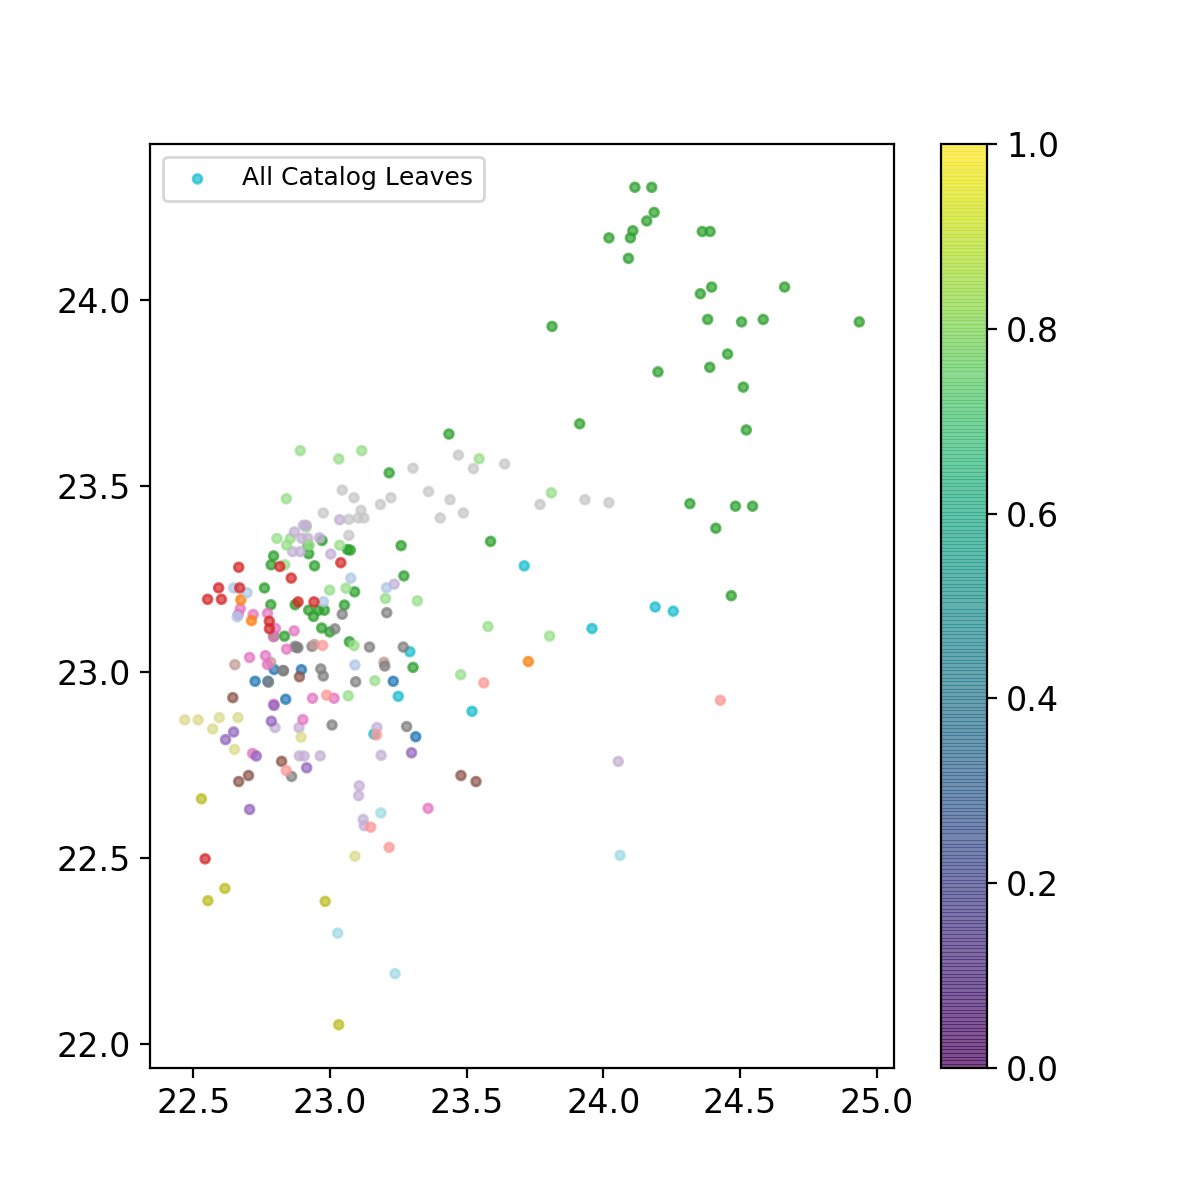

In [49]:
##########################################################
### playing around with overdensity
#########################################################
from matplotlib import cm
# new "shower" figure based on adam's suggestion
plt.close()
plt.rcParams.update({'font.size': 12}) #set fontsize
fig, ax = plt.subplots(figsize=(6,6))
N_Herschel=catalog['herschel_column']
N_SMA = catalog['sma_column']

#cmap = cm.get_cmap('viridis',35)
cmap=cm.get_cmap('tab20')

# ax.scatter(catalog['glon'], N_SMA/N_Herschel, 
sc = ax.scatter(np.log10(N_SMA),np.log10(N_Herschel), 
           c=cmap((catalog['mask_num']-1)/35.),
           cmap=cmap, alpha=0.7,
           label='All Catalog Leaves',marker='o',s=10.)
plt.colorbar(c,)

# ax.set_xlim(-1.4,-0.4)
# ax.set_ylim(0,5.0)

legend = plt.legend(loc='upper left', shadow=False, fontsize=9)#'x-large')

plt.show()



In [32]:
cmap(np.array((catalog['mask_num']-1)))

array([[0.845561, 0.887322, 0.099702, 1.      ],
       [0.845561, 0.887322, 0.099702, 1.      ],
       [0.845561, 0.887322, 0.099702, 1.      ],
       [0.13777 , 0.537492, 0.554906, 1.      ],
       [0.13777 , 0.537492, 0.554906, 1.      ],
       [0.13777 , 0.537492, 0.554906, 1.      ],
       [0.13777 , 0.537492, 0.554906, 1.      ],
       [0.13777 , 0.537492, 0.554906, 1.      ],
       [0.13777 , 0.537492, 0.554906, 1.      ],
       [0.13777 , 0.537492, 0.554906, 1.      ],
       [0.13777 , 0.537492, 0.554906, 1.      ],
       [0.13777 , 0.537492, 0.554906, 1.      ],
       [0.13777 , 0.537492, 0.554906, 1.      ],
       [0.13777 , 0.537492, 0.554906, 1.      ],
       [0.13777 , 0.537492, 0.554906, 1.      ],
       [0.688944, 0.865448, 0.182725, 1.      ],
       [0.688944, 0.865448, 0.182725, 1.      ],
       [0.688944, 0.865448, 0.182725, 1.      ],
       [0.688944, 0.865448, 0.182725, 1.      ],
       [0.688944, 0.865448, 0.182725, 1.      ],
       [0.688944, 0.